<a href="https://colab.research.google.com/github/svneha/DRUG-CLASSIFICATION-USING-ANN/blob/main/APA_EXPERIMENT_3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# libraries for text processing and handling text data
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

from collections import Counter

# all the required models
from sklearn.neighbors import KNeighborsClassifier

# for model evaluation
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore') # To prevent kernel from showing any warning

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## READING THE DATASET

In [2]:
# load dataset
df = pd.read_csv('https://raw.githubusercontent.com/eprayoga/Spam-Ham-Email-Classification-KNN/main/Datasets/completeSpamAssassin.csv')
df.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [3]:
df.shape

(6046, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6046 non-null   int64 
 1   Body        6045 non-null   object
 2   Label       6046 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 141.8+ KB


## CLEANING THE DATA SET

In [5]:
df.isnull().sum()

Unnamed: 0    0
Body          1
Label         0
dtype: int64

In [6]:
df.duplicated().sum()

0

### FEATURE ENGINEERING

In [7]:
df.dropna(inplace=True)
df.drop(['Unnamed: 0'],axis=1, inplace=True)

In [8]:
df.isnull().sum()

Body     0
Label    0
dtype: int64

In [9]:
## Hence there are no null values and duplicates in the data set , hence the data is clean

In [10]:
df['no_char'] = df['Body'].apply(len)
df['no_words'] = df['Body'].apply(lambda x:len(nltk.word_tokenize(x)))
df['no_sent'] = df['Body'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [11]:
df.head()

,Body,Label,no_char,no_words,no_sent
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,191,12
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,139,5
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,113,4
3,##############################################...,1,2863,690,35
4,I thought you might like these:\n1) Slim Down ...,1,641,108,4


## Visualization

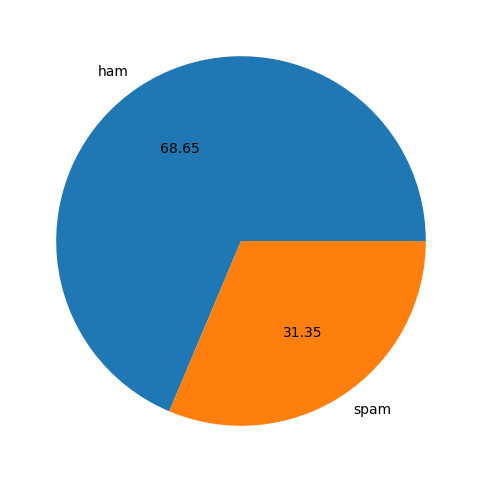

In [12]:
plt.figure(figsize=(12,6))
plt.pie(df['Label'].value_counts(), labels=['ham','spam'], autopct='%0.2f')
plt.show()

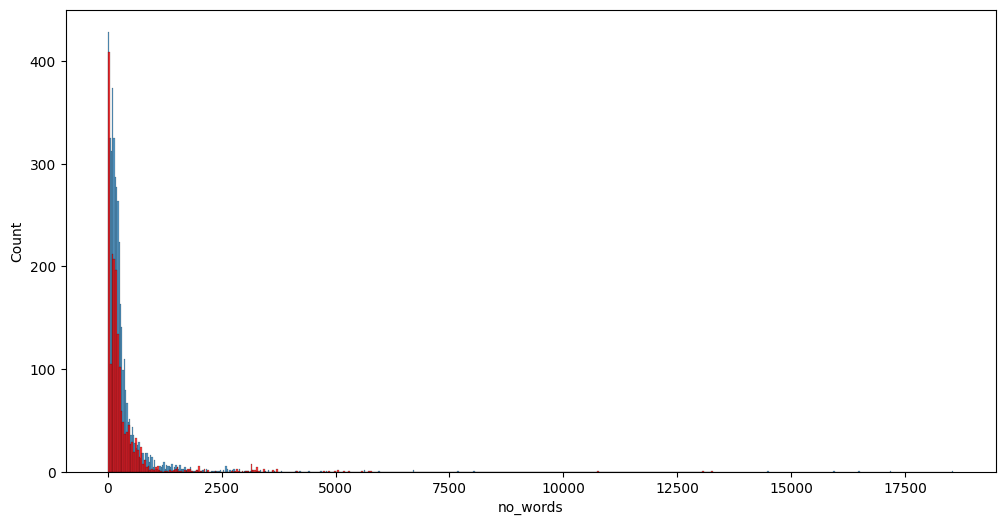

In [13]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['Label'] == 0]['no_words'])
sns.histplot(df[df['Label'] == 1]['no_words'], color='red')
plt.show()

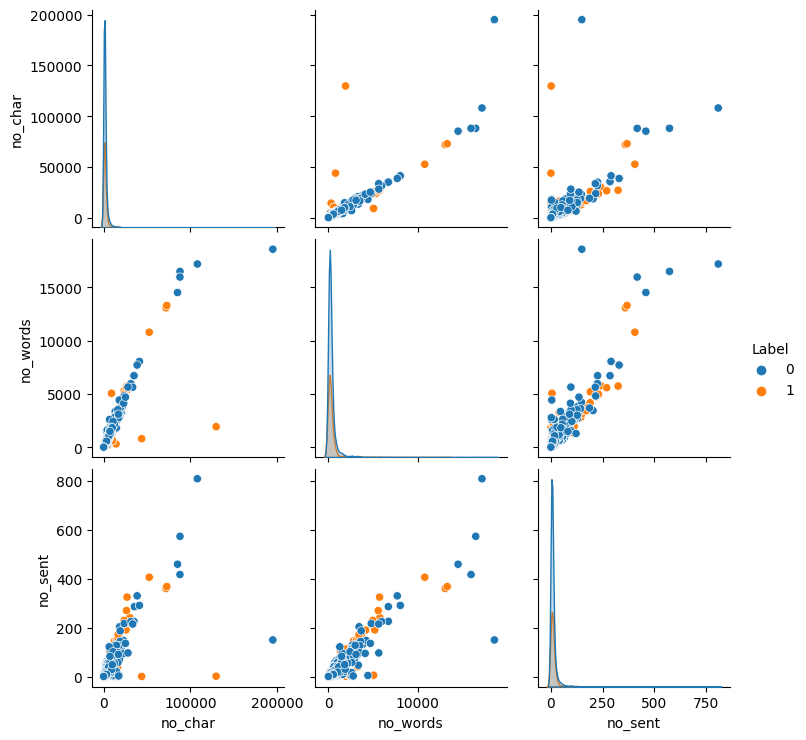

In [14]:
sns.pairplot(df, hue='Label')
plt.show()

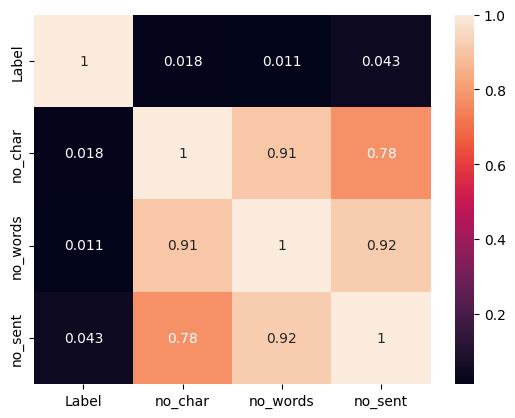

In [15]:
sns.heatmap(df.corr(), annot=True)
plt.show()

## TEXT PROCESSING

In [16]:
def text_preprocessing(text):
    # convert  text to lowecase
    text = text.lower()

    # creating list of words in email
    text = nltk.word_tokenize(text)

    # removing special charecters
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    # copying processed text to text and clearing y to store next steps output
    text = y[:]
    y.clear()

    # removing stopwords and punctuation marks
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    # stemming
    stemmer = SnowballStemmer('english')
    for i in text:
        y.append(stemmer.stem(i))

    return " ".join(y)

In [17]:
df['clean_text'] = df['Body'].apply(text_preprocessing)

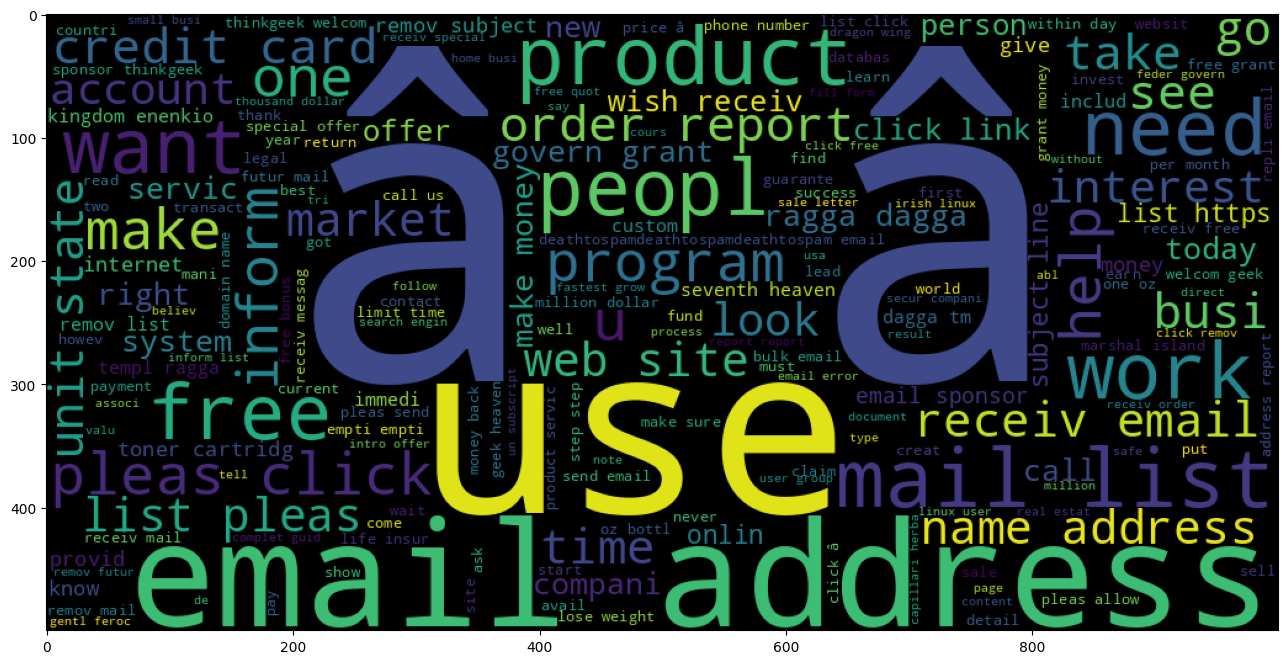

In [18]:
wc = WordCloud(width=1000, height=500, min_font_size=10, background_color='black')

spam_wc = wc.generate(df[df['Label'] == 1]['clean_text'].str.cat(sep=' '))

plt.figure(figsize=(20,8))
plt.imshow(spam_wc)

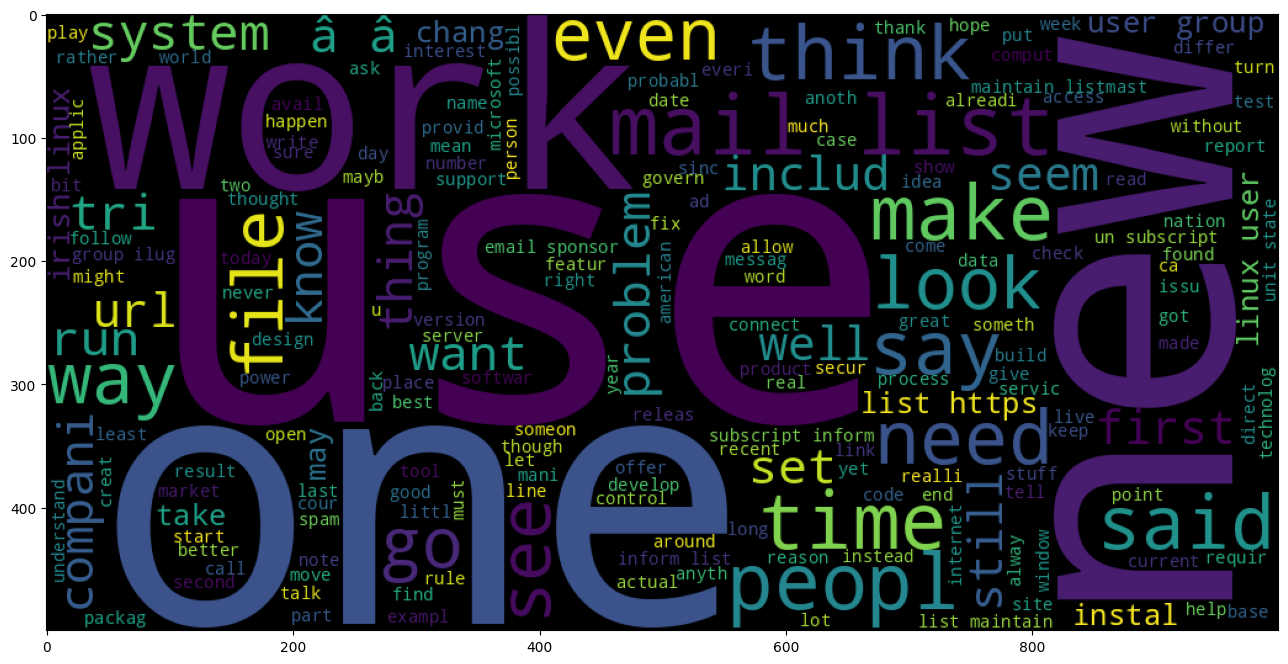

In [19]:
ham_wc = wc.generate(df[df['Label'] == 0]['clean_text'].str.cat(sep=' '))

plt.figure(figsize=(20,8))
plt.imshow(ham_wc)

In [20]:
spam_corpus = []
for mail in df[df['Label'] == 1]['clean_text'].tolist():
    for word in mail.split():
        spam_corpus.append(word)

# number of words in all spam mails
len(spam_corpus)

276886

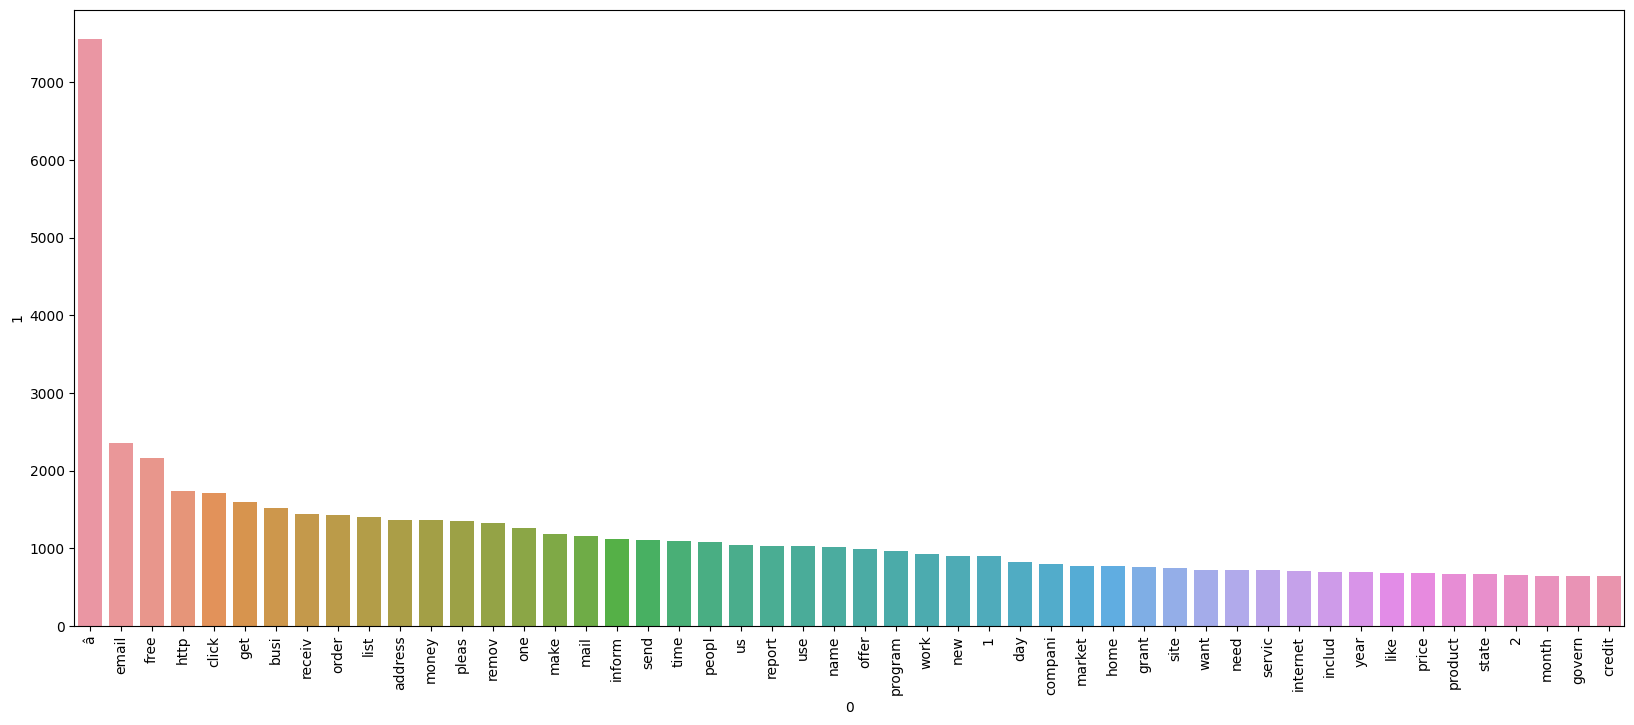

In [21]:
plt.figure(figsize=(20,8))
sns.barplot(x = pd.DataFrame(Counter(spam_corpus).most_common(50))[0], y = pd.DataFrame(Counter(spam_corpus).most_common(50))[1])
plt.xticks(rotation='vertical')
plt.show()

In [22]:
ham_corpus = []
for mail in df[df['Label'] == 0]['clean_text'].tolist():
    for word in mail.split():
        ham_corpus.append(word)

# number of words in all ham mails
len(ham_corpus)

547669

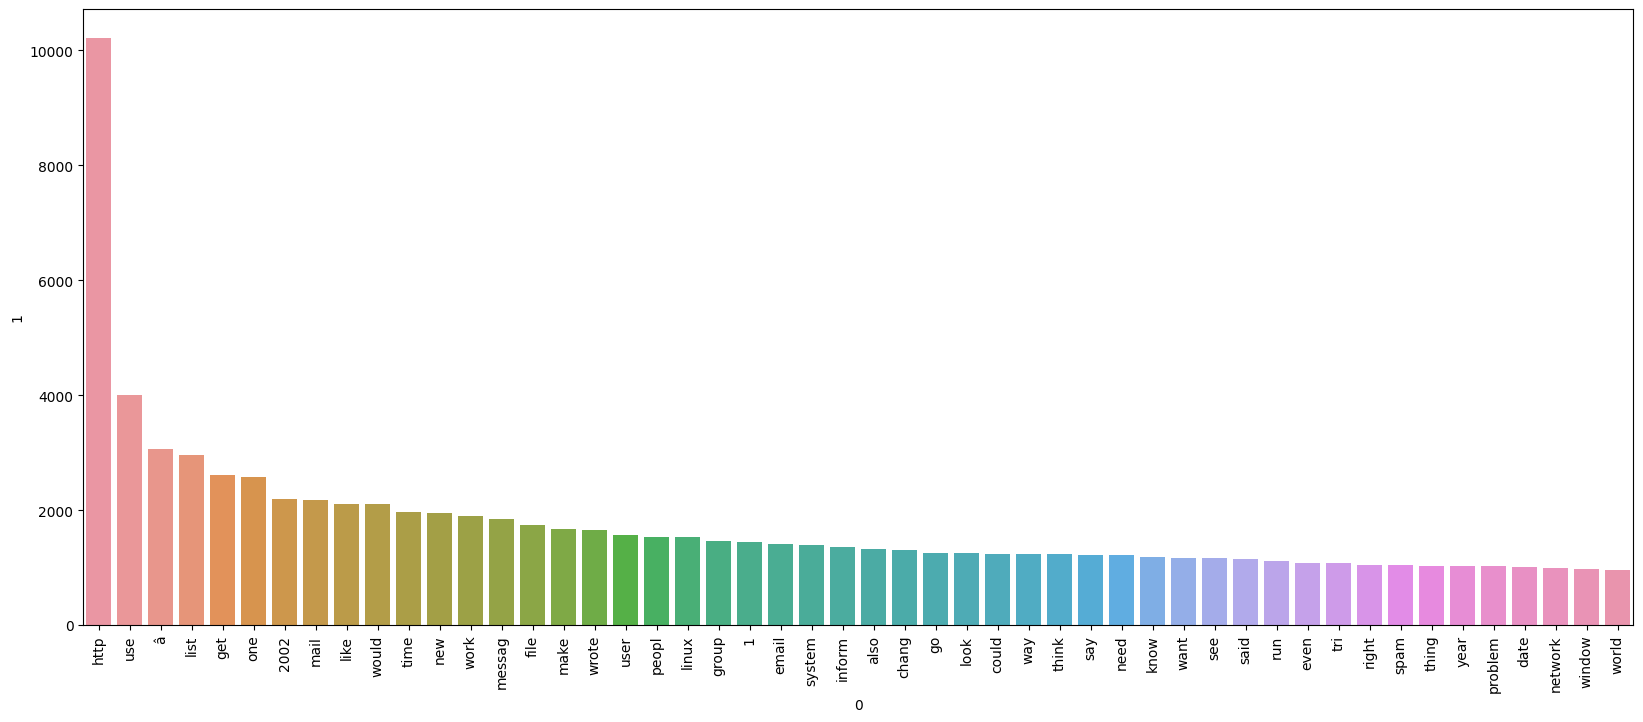

In [23]:
plt.figure(figsize=(20,8))
sns.barplot(x = pd.DataFrame(Counter(ham_corpus).most_common(50))[0], y = pd.DataFrame(Counter(ham_corpus).most_common(50))[1])
plt.xticks(rotation='vertical')
plt.show()

## TRAIN TEST SPLIT

In [24]:
# tfidf = TfidfVectorizer()
tfidf = TfidfVectorizer(max_features=17000)

# Setting up features and target as x and y
x = tfidf.fit_transform(df['clean_text']).toarray()
y = df['Label'].values

# Splitting the testing and training sets
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

TRAINING KNN MODEL

In [25]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [26]:
y_pred = knn.predict(x_test)
accuracy = accuracy_score(y_test,y_pred)

print('KNN model accuracy = ' + str('{:4.2f}'.format(accuracy*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, y_pred))


KNN model accuracy = 39.78%
------------------------------------------------
Confusion Matrix:
     0    1
0  107  728
1    0  374
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.13      0.23       835
           1       0.34      1.00      0.51       374

    accuracy                           0.40      1209
   macro avg       0.67      0.56      0.37      1209
weighted avg       0.80      0.40      0.31      1209



## REBUILD KNN MODEL

In [27]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [28]:
y_pred = knn.predict(x_test)
accuracy = accuracy_score(y_test,y_pred)

print('KNN Model using k=3 model accuracy = ' + str('{:4.2f}'.format(accuracy*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, y_pred))

In [29]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [30]:
y_pred = knn.predict(x_test)
accuracy = accuracy_score(y_test,y_pred)

print('KNN Model using k=5 model accuracy = ' + str('{:4.2f}'.format(accuracy*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, y_pred))

KNN Model using k=5 model accuracy = 39.78%
------------------------------------------------
Confusion Matrix:
     0    1
0  107  728
1    0  374
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.13      0.23       835
           1       0.34      1.00      0.51       374

    accuracy                           0.40      1209
   macro avg       0.67      0.56      0.37      1209
weighted avg       0.80      0.40      0.31      1209



In [31]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [32]:
y_pred = knn.predict(x_test)
accuracy = accuracy_score(y_test,y_pred)

print('KNN Model using k=7 model accuracy = ' + str('{:4.2f}'.format(accuracy*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, y_pred))

KNN Model using k=7 model accuracy = 84.78%
------------------------------------------------
Confusion Matrix:
     0    1
0  655  180
1    4  370
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.78      0.88       835
           1       0.67      0.99      0.80       374

    accuracy                           0.85      1209
   macro avg       0.83      0.89      0.84      1209
weighted avg       0.89      0.85      0.85      1209



In [33]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [34]:
y_pred = knn.predict(x_test)
accuracy = accuracy_score(y_test,y_pred)

print('KNN Model using k=9 model accuracy = ' + str('{:4.2f}'.format(accuracy*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, y_pred))

KNN Model using k=9 model accuracy = 86.10%
------------------------------------------------
Confusion Matrix:
     0    1
0  675  160
1    8  366
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.81      0.89       835
           1       0.70      0.98      0.81       374

    accuracy                           0.86      1209
   macro avg       0.84      0.89      0.85      1209
weighted avg       0.90      0.86      0.87      1209

